In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import HTML
from matplotlib.patches import Rectangle, Circle, Arrow
from matplotlib import animation, rc, image
from matplotlib.transforms import Affine2D # 2D translation and rotation
#import seaborn as sns
import math
from math import sin, cos

# saves matplotlib output
%matplotlib inline 

  # Load RL Policy

In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print('Not running on CoLab')

Running on CoLab
Mounted at /content/drive


In [3]:
if 'google.colab' in str(get_ipython()):
  %cd "/content/drive/My Drive/2020 Optimal Control"

/content/drive/My Drive/2020 Optimal Control


In [31]:
FROM_CPU = True
policy_parameters = np.loadtxt('dd_parameters.m') #oriented RL
#np.loadtxt('dd_parameters_non_stochastic_naive_long.m')
#np.loadtxt('dd_parameters_non_stochastic_long.m') #oriented RL
#np.loadtxt('dd_parameters_forward_prop_no_penalty.m') #future RL
#np.loadtxt('dd_parameters_CUDA_TEST.m')
#np.loadtxt('dd_parameters_forward_prop_no_penalty.m')
#np.loadtxt('dd_parameters_3_200_4.m') 
#np.loadtxt('dd_parameters_long.m') 
#np.loadtxt('dd_parameters_non_stochastic_long.m')
print(policy_parameters.shape)

def GenFeature(x, g):
    diff = g[:2] - x[:2]
    rotdifx = np.cos(-x[2]) * diff[0] - np.sin(-x[2]) * diff[1]
    rotdify = np.sin(-x[2]) * diff[0] + np.cos(-x[2]) * diff[1]
    return np.array([rotdifx,rotdify,x[2]])

def RL_policy(feature, parameters):
  in_size = 3
  hidden_size = 200
  out_size = 4
  W1 = parameters[:in_size*hidden_size]
  print(W1[:3])
  if FROM_CPU:
    W1 = np.reshape(W1,(in_size,hidden_size)).T
  else:
    W1 = np.reshape(W1,(hidden_size,in_size,))
  B1 = parameters[in_size*hidden_size : in_size*hidden_size+hidden_size]
  print(B1[:3])
  B1 = np.reshape(B1,(hidden_size))
  W2 = parameters[in_size*hidden_size+hidden_size : in_size*hidden_size + hidden_size + out_size*hidden_size]
  print(W2[:3])
  if FROM_CPU:
    W2 = np.reshape(W2,(hidden_size,out_size)).T
  else:
    W2 = np.reshape(W2,(out_size,hidden_size))
  B2 = parameters[in_size*hidden_size + hidden_size + out_size*hidden_size :]
  print(B2[:3])
  B2 = np.reshape(B2,(out_size))
  print(W1.shape,W2.shape,B1.shape,B2.shape)
  return (W2 @ np.maximum( W1 @ feature + B1 , 0) + B2)[:2] # only return the mean

RL_policy(np.zeros(3),policy_parameters)

(1604,)
[0.450911 0.444467 0.985523]
[ 0.734129  0.148512 -0.525674]
[-0.133064 -0.154935  0.113343]
[-0.095833 -0.626742 -0.476847]
(200, 3) (4, 200) (200,) (4,)


array([0.5966024 , 1.42636781])

# Simulation Setup

In [5]:
policy = lambda W, x : np.array([-40,4],dtype=np.float)
#init_state = np.array([0,0,0])


#Simulation paramters
dt = 0.1    #seconds
runtime = 8 #seconds

#Target task
car_start = np.array((-25,0,0.751))
car_goal = np.array((25,0,0))

agent_states = [car_start, np.array([0,0,0])]
agent_types = ['diffdrive','diffdrive']


#Car dynamics paramters
v_max = 30  #units/sec
omega_max = math.pi #pi radians/sec = 180 deg/sec turn speed

#Car shape
car_l = 4.7 #10
car_w = car_l/2.0 #1.9 #5
car_r = car_l * math.sqrt(5) / 4.0 #2.35

# Cost image shape
imsize = (100,100)

kappa_goal = 1.0

In [6]:
# Best function ever
def RemapRange (value, low1, high1, low2, high2):
  return low2 + (value - low1) * (high2 - low2) / (high1 - low1)

# pix_x = 50
# [0,100] -> [-1,1]

NormalizeSpace = lambda x,a,b : RemapRange(x,a,b,-1,1)

Pix2Vel = lambda x,a,b : RemapRange(x,a,b,-v_max,v_max)
Pix2Omega = lambda x,a,b : omega_max * NormalizeSpace(x,a,b)

print(Pix2Omega(100,0,100))
print(Pix2Vel(100,0,100))

3.141592653589793
30.0


# Time to Collision Code
This function assumes that the velocity across the time period is constant, and returns the time at which collision occurs. This is inf if there is no collision.

In [7]:
def TimeToCollision(xA, vA, rA, xB, vB, rB):
  w = xB-xA
  v = vB-vA
  a = v @ v
  b = 2 * w @ v
  c = w @ w - (rA+rB)**2
  discriminant = b*b - 4*a*c
  print(discriminant)
  # if discriminant < 0:
  if a == 0:
    return math.inf
  if discriminant < 0:
    return math.inf
  tau_pos = (-b + math.sqrt(b*b - 4*a*c))/(2*a)
  tau_neg = (-b - math.sqrt(b*b - 4*a*c))/(2*a)
  if tau_pos < 0 and tau_neg < 0:
    return math.inf
  elif tau_pos > 0 or tau_neg > 0: # agents are either colliding or will collide
    if tau_pos < 0 or tau_neg < 0: # one solution is negative and one is positive; currently colliding
      return 0
    else: # will collide in the near future
      return min(tau_pos,tau_neg)

def TimeToCollisionFast(xA, vA, rA, xB, vB, rB):
  w = xB-xA
  v = vB-vA
  a = v @ v
  b = -w @ v
  c = w @ w - (rA+rB)**2
  discriminant = b*b - a*c
  print(discriminant)
  # if discriminant < 0:
  if a == 0:
    return math.inf
  if discriminant < 0:
    return math.inf
  tau_pos = (b + math.sqrt(discriminant))/a
  tau_neg = (b - math.sqrt(discriminant))/a
  if tau_pos < 0 and tau_neg < 0:
    return math.inf
  elif tau_pos > 0 or tau_neg > 0: # agents are either colliding or will collide
    if tau_pos < 0 or tau_neg < 0: # one solution is negative and one is positive; currently colliding
      return 0
    else: # will collide in the near future
      return min(tau_pos,tau_neg)


In [8]:
# def TimeToCollisionTrajectory(xA, uA, rA, xB, uB, rB,):


In [9]:
Dynamics = {'car'       : (lambda x,u : np.array([u[0] * math.cos(x[2]), u[0] * math.sin(x[2]), x[0] / car_l * math.tan(x[1])])),
            'diffdrive' : (lambda x,u : np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])) }

# Runga Kutta 1 (basic first-order Eulerian update)
def FixedUpdate( state, control, dynamics, dt):
  return state + dt * dynamics(state, control) # f(x,u)

def update_state(params, cur_state, goal, policy): # TODO: make clipping a function parameter
  #Read Current State
  cx = cur_state[0]
  cy = cur_state[1]
  theta = cur_state[2]
  gx = goal[0]
  gy = goal[1]

  #Apply Policy
  action = policy(params, (cx, cy, theta, gx, gy)) # TODO: NH-TTC

  #Clamp actions to feasible set
  action[0] = np.clip(action[0],-v_max,v_max)
  action[1] = np.clip(action[1], -omega_max, omega_max)

  #Apply dynamic model (Eulerian Integration)
  x_next = FixedUpdate(cur_state, action, Dynamics['diffdrive'],dt)

  return (x_next[0],x_next[1],x_next[2]), action #(cx, cy, theta), action   #new state, action 

In [10]:
np.eye(3)[:2]

array([[1., 0., 0.],
       [0., 1., 0.]])

In [11]:
def Algorithm2 (u, x_0, tau, dt, dynamic_model):

  t = 0
  dx_du = np.zeros((3,2))
  x = np.copy(x_0)
  while t < tau:
    dt = min(dt,tau-t)
    x = FixedUpdate(x,u,Dynamics[dynamic_model],dt)
    # Equation 15 FOR DIFF DRIVE, TODO: make generic
    px_pu = dt * np.array([[np.cos(x[2]),0],[np.sin(x[2]),0],[0,1]])
    px_plus_1_px = np.array([[1,0,-u[0]*np.sin(x[2])],[0,1,u[0]*np.cos(x[2])],[0,0,1]])

    dx_du = px_pu + px_plus_1_px @ dx_du
    t += 1
  return dx_du

In [12]:
def GetCollisionCenter_Car(x,L):
  x_bar = x[0] + 0.5*L * np.cos(x[2])
  y_bar = x[1] + 0.5*L * np.sin(x[2])
  return np.array([x_bar,y_bar])

CollisionCenter = {'car'       : (lambda x : GetCollisionCenter_Car(x,car_l)),
                   'diffdrive' : (lambda x : np.array([x[0],x[1]])) }

def Cost_Goal_Raw(x_bar,p_goal):
  difference = x_bar[:2] - p_goal[:2]
  return kappa_goal * math.sqrt(difference @ difference)

def UpdateTimeHorizon(x,u,tau,dt,dynamic_model):
  x_update = np.copy(x)
  dynamics = Dynamics[dynamic_model]
  for t in range(tau):
    x_update = FixedUpdate( x_update, u, dynamics, dt)
  return x_update

def Cost_Goal(u,tau,dt,dynamic_model,x,p_goal):
  # Simulate the agent for time_horizon steps with the given control
  #dynamics = Dynamics[dynamic_model]
  x_tau = UpdateTimeHorizon(x,u,tau,dt,dynamic_model)
  x_bar = CollisionCenter[dynamic_model](x_tau)
  return Cost_Goal_Raw(x_bar, p_goal)


def Grad_Cost_Goal(u,tau,dt,dynamic_model,x,p_goal):
  # dC/dXBar
  x_tau = UpdateTimeHorizon(x,u,tau,dt,dynamic_model)
  x_bar = CollisionCenter[dynamic_model](x_tau)
  difference = x_bar[:2] - p_goal[:2] # 2 element vector
  dC_dx_bar = (kappa_goal / np.linalg.norm(difference)) * difference
  
  # Only for differential drive TODO: make generic
  dx_bar_dx = np.eye(3)[:2]

  dx_du = Algorithm2 (u, x, tau, dt, dynamic_model)

  # print(dC_dx_bar.shape)
  # print(dx_bar_dx.shape)
  # print(dx_du.shape)


  return dC_dx_bar @ dx_bar_dx @ dx_du


# Cost_Goal_U = lambda u : Cost_Goal(u,;lajsdflk;jasldfkjals;kjdf)
# Cost_Goal_U(u)
#def Cost_

test_x = np.array([1,2])
test_y = np.array([-3,8.3])
print(Cost_Goal_Raw(test_x,test_y))



7.462573282722255


In [13]:
def Algorithm1 (u_0, Constraints, c_lowest, maxTime, tau, x, dynamic_model, p_goal): # maxTime will be an integer for now
  k = 0
  u_star = u_0
  u_k    = u_0
  c_plus = Cost_Goal(u_0,tau,dt,dynamic_model,x,p_goal)
  c_k    = c_plus
  s_k = np.zeros(2) # column vector
  t = 0
  while t < maxTime:
    #print(u_star)
    g_k = Grad_Cost_Goal(u_k, tau, dt, dynamic_model, x, p_goal)                 # True Gradient
    #print(g_k)
    s_k = 0.1 * s_k + 0.9 * g_k         # Momentum
    c_hat_star_k =  c_plus + (c_lowest - c_plus) * 10/(10 + k)
    alpha = (c_k - c_hat_star_k)/(s_k @ s_k)  # Subgradient step size
    u_k_plus_1 = u_k - alpha * s_k            # Subgradient descent
    #print(u_k_plus_1)
    u_k        = Constraints(u_k_plus_1)      # Project onto Constraints
    c_k        = Cost_Goal(u_k_plus_1,tau,dt,dynamic_model,x,p_goal)      # Get new cost to Goal

    if c_k < c_plus:                  # Only keep control with best cost seen
      c_plus = c_k
      u_star = u_k
    # c_plus = c_k
    # u_star = u_k
    k += 1
    t += 1
  return u_star

constraint = lambda u : np.array([np.clip(u[0],-v_max,v_max), np.clip(u[1], -omega_max, omega_max)])

#NHTTC_Policy = lambda u,x,c_lowest, : Algorithm1 (u, constraint, c_lowest, maxTime, tau, x, dynamic_model, p_goal): # maxTime will be an integer for now

def NHTTC_Policy(u,x): #TODO: make generic
  #c_lowest = Cost_Goal(u,5,dt,'diffdrive',x,car_goal)
  diff = x[:2] - car_goal[:2]
  current_distance = np.linalg.norm(diff)
  c_lowest = max(current_distance - v_max * dt * 5, 0.0)
  return Algorithm1(u,constraint,c_lowest,2000,5,x,'diffdrive',car_goal)


In [14]:
  agent_states = [car_start, np.array([14,14,1.25]), np.array([-20,-30,-1]), np.array([-15,35,-2]), np.array([5,-25,.5]), np.array([40,-5,.2]), np.array([0,0,-3.14])]#, np.array([0,0,0])] #[np.array([0,0,-3.14])]
  agent_types = ['diffdrive','diffdrive','diffdrive','diffdrive','diffdrive','diffdrive','diffdrive']#,'diffdrive']

In [15]:
def RunSimulation(params, init_state, goal_pos):
  #state_list = []
  #action_list = []

  state_lists = []
  action_lists = []


  future_states = []

  for i in range(len(agent_states)):
    state_lists.append([])
    action_lists.append([])
    future_states.append([])
    # for f in range(5):
    #   future_states[i].append([])

  # cur_state = init_state
  # state_list.append(cur_state)

  sim_time = runtime
  reward = 0

  time_horizon = 5

  sim_steps = int(sim_time/dt)
  sim_steps = 60

  
  cost_visualization = np.zeros((sim_steps,*imsize)) # holds the cost function images relating to actions


  u = np.array([0,0])
  # Get first state for all agents
  for (aidx, astate) in enumerate(agent_states):
    state_lists[aidx].append(astate)
    future_states[aidx].append([])
    next_state = np.copy(astate)
    for f in range(time_horizon):
      next_state = FixedUpdate(next_state,u,Dynamics['diffdrive'],dt)#update_state(params, next_state, goal_pos, policy)
      #next_state, _ = update_state(params, next_state, goal_pos, policy)
      future_states[aidx][0].append(next_state)
  
  x = np.copy(astate)

  # Simulate all agents (run one update per timestep)
  for t in range(sim_steps):
    print('Step:',t,'/',sim_steps)
    for aidx in range(len(agent_states)): #aidx = agent_index
      # if aidx == 1:
      #   u = NHTTC_Policy(u,state_lists[aidx][t]) #policy(None,state_lists[aidx][t]) #NHTTC_Policy
      # else:
      feat = GenFeature(state_lists[aidx][t],goal_pos)
      if t == 0:
        u = np.array([0,0]) 
      else:
        u = action_lists[aidx][t-1]
      u = RL_policy(feat,policy_parameters) #NHTTC_Policy(u,state_lists[aidx][t]) #
      u = constraint(u)
      print('u',u)
      print('x',state_lists[aidx][t])
      u = constraint(u)
      x = FixedUpdate(state_lists[aidx][t],u,Dynamics['diffdrive'],dt)
      #x, new_action = update_state(params, state_lists[aidx][t], goal_pos, policy)
      state_lists[aidx].append(x)
      action_lists[aidx].append(u)
      
      # Get the next 5 future states using eulerian integration with a single control
      future_states[aidx].append([])
      next_state = x
      for f in range(time_horizon):
        next_state = FixedUpdate(next_state,u,Dynamics['diffdrive'],dt)#update_state(params, next_state, goal_pos, policy)
        future_states[aidx][t+1].append(next_state)

      if aidx == 0:
        for i in range(imsize[0]):
          for j in range(imsize[1]):
            control = np.zeros(2)
            control[0] = Pix2Vel(j, 0, imsize[1])
            control[1] = -Pix2Omega(i, 0, imsize[0])

            # Simulate the agent for time_horizon steps with the given control
            # next_state = x
            # TempPolicy = lambda W, x : control # TODO: fix code so update_state maybe doesn't use policy?
            # for f in range(time_horizon):
            #   next_state, _ = update_state(params, next_state, goal_pos, TempPolicy)
            
            # cost = Cost_Goal_Raw(next_state, car_goal)
            cost = Cost_Goal(control,5,dt,agent_types[aidx],x,goal_pos)
            cost_visualization[t,i,j] = cost

            

    
  #print(action_list)
  return state_lists,action_lists,cost_visualization,future_states

In [16]:
#Dynamics[agent_types[1]]

# Run Simulation and Save States

In [17]:
states, actions, cost_imgs, future_states = RunSimulation(None,car_start,car_goal)

Step: 0 / 60
[0.450911 0.444467 0.985523]
[ 0.734129  0.148512 -0.525674]
[-0.133064 -0.154935  0.113343]
[-0.095833 -0.626742 -0.476847]
(200, 3) (4, 200) (200,) (4,)
u [30.         -3.14159265]
x [-25.      0.      0.751]
[0.450911 0.444467 0.985523]
[ 0.734129  0.148512 -0.525674]
[-0.133064 -0.154935  0.113343]
[-0.095833 -0.626742 -0.476847]
(200, 3) (4, 200) (200,) (4,)
u [-17.27075885   3.14159265]
x [14.   14.    1.25]
[0.450911 0.444467 0.985523]
[ 0.734129  0.148512 -0.525674]
[-0.133064 -0.154935  0.113343]
[-0.095833 -0.626742 -0.476847]
(200, 3) (4, 200) (200,) (4,)
u [-30.          -3.14159265]
x [-20 -30  -1]
[0.450911 0.444467 0.985523]
[ 0.734129  0.148512 -0.525674]
[-0.133064 -0.154935  0.113343]
[-0.095833 -0.626742 -0.476847]
(200, 3) (4, 200) (200,) (4,)
u [-30.           3.14159265]
x [-15  35  -2]
[0.450911 0.444467 0.985523]
[ 0.734129  0.148512 -0.525674]
[-0.133064 -0.154935  0.113343]
[-0.095833 -0.626742 -0.476847]
(200, 3) (4, 200) (200,) (4,)
u [30.      

In [18]:
# print(len(states))
print(len(states[0]))
# print(len(states[1]))
# print(states[1][1][0])
# print(int(8/dt))
# print(cost_imgs.shape[0])
# print(actions[0][0][1])
# print(len(future_states[0]))
# print(actions[0])
print(len(actions[0]))
print(actions[0][0])
print(states[0][0])

61
60
[30.         -3.14159265]
[-25.      0.      0.751]


#Analysis

In [19]:
# distances = np.zeros(len(agent_states))
# times = np.zeros(len(agent_states))
# changeofcontrol = np.zeros(len(agent_states))
# for aidx in range(len(agent_states)):
#   for t in range(len(states[aidx])):
#     if t == 0:
#       continue
#     cur_state = states[aidx][t][:2]
#     prv_state = states[aidx][t-1][:2]
#     diff = cur_state-prv_state
#     dist = np.linalg.norm(diff)
#     distances[aidx] += dist
#     if t == len(states[aidx])-1:
#       print("final dist:", np.linalg.norm( car_goal[:2] - cur_state[:2]))
#     if t < len(states[aidx])-1:
#       cur_control = actions[aidx][t]
#       prv_control = actions[aidx][t-1]
#       cdiff = cur_control-prv_control
#       cdist = np.linalg.norm(cdiff)
#       changeofcontrol[aidx] += cdist

#     times[aidx] += dt
#     if (np.linalg.norm( car_goal[:2] - cur_state[:2]) < 1):
#       print("final dist:", np.linalg.norm( car_goal[:2] - cur_state[:2]))
#       break

# print(distances)
# print(changeofcontrol)
# print(times)

In [20]:
# distdiff = distancesRL - distancesNHTTC
# timediff = timesRL - timesNHTTC
# changeofcontroldiff = changeofcontrolRL - changeofcontrolNHTTC
# print(distdiff)
# print(changeofcontroldiff)
# print(timediff)

In [21]:
# changeofcontrolRL = changeofcontrol
# distancesRL = distances
# timesRL = times

In [22]:
# distancesNHTTC = distances
# timesNHTTC = times
# changeofcontrolNHTTC = changeofcontrol

In [23]:

# print(distancesRL)
# print(changeofcontrolRL)
# print(timesRL)
# print('------')
# print(distancesNHTTC)
# print(changeofcontrolNHTTC)
# print(timesNHTTC)

# Animate Saved States

Rendering 61 frames


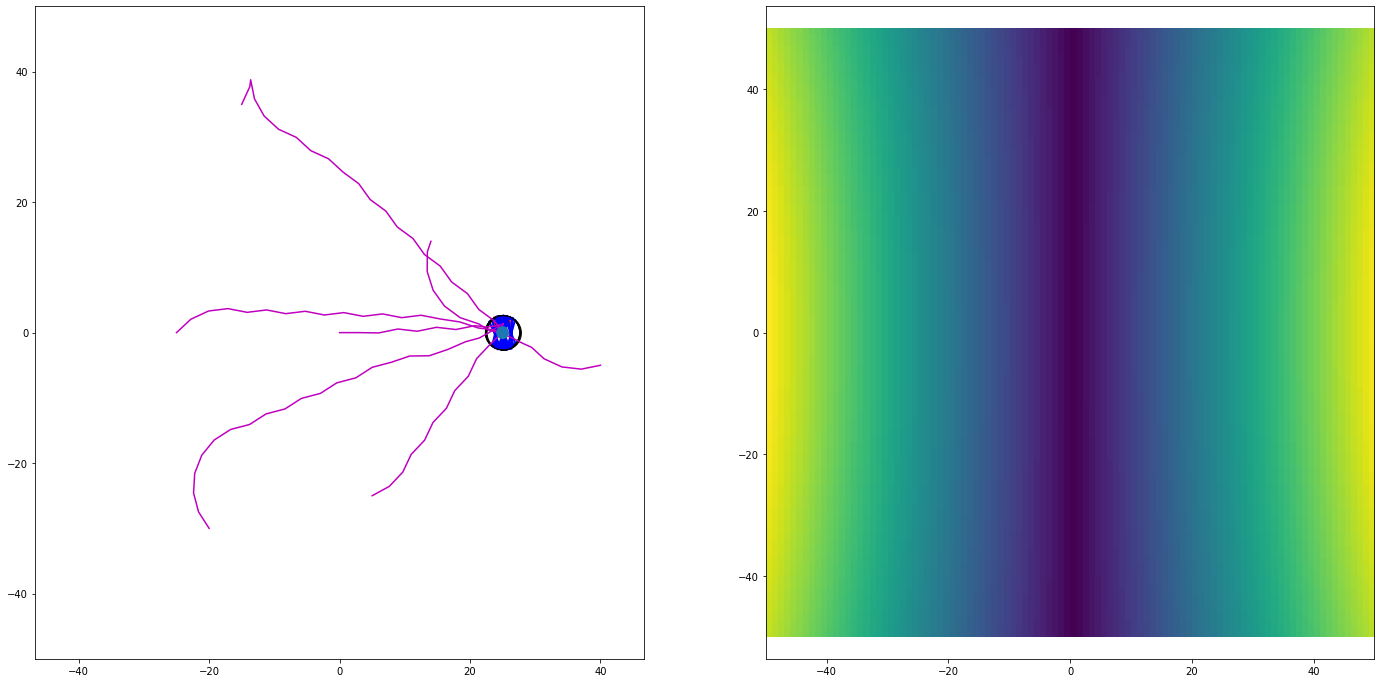

In [24]:
# TODO: Should add a framerate, so that we can seperate simulation time from animation time. i.e. draw only every other frame.

#training_generator testing_generator
#batch_idx, (input_crowd, traget_crowd) = next(enumerate(training_generator))
#start = input_crowd[0]

#%matplotlib inline

showFuture = False
render_w = 50
render_h = 50
fig, axs = plt.subplots(nrows=1, ncols=2)

fig.set_size_inches(24, 12)
#fig = plt.figure()
# ax1  = plt.axes(xlim=(0, 22), ylim=(32, 0))
# ax2  = plt.axes(xlim=(0, 22), ylim=(32, 0))
# axs[0].set_title('Test1')
# axs[0].set_xlim(0,image_w)
# axs[0].set_ylim(image_h,0)
# axs[0].autoscale(False)
#axs[0].axis('off')
# axs[1].set_title('Cost')
# axs[1].set_xlim(-v_max,v_max)
# axs[1].set_ylim(omega_max,-omega_max)
# axs[1].autoscale(False)


#plt.close()


frames_to_draw = len(states[0])
print("Rendering",frames_to_draw,"frames")

#Matplot lib animation magic...
#Check here for a lot more: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# fig = plt.figure()
# # axs[0] = plt.gca()
# # axs[1] = plt.gca()
# axs[0].gca()
# axs[1].gca()
img1 = axs[1].imshow(np.zeros(imsize),extent=[-imsize[1]/2., imsize[1]/2., -imsize[0]/2., imsize[0]/2. ])

def init():
  axs[0].cla()
  axs[0].axis('equal')
  axs[0].set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  axs[1].cla()
  axs[1].axis('equal')
  #img1.set_data(np.zeros(imsize))
  axs[1].imshow(np.zeros(imsize),extent=[-imsize[1]/2., imsize[1]/2., -imsize[0]/2., imsize[0]/2. ])
  axs[1].set(xlim=(-imsize[0]/2, imsize[0]/2),ylim=(-imsize[1]/2, imsize[1]/2))
  
  return fig,

def animate(t):
  axs[0].cla()
  axs[0].axis('equal')
  #Draw area
  axs[0].set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  #Draw goal
  goal_w = car_l
  #rect = Rectangle((car_goal[0]-goal_w/2,car_goal[1]-goal_w/2),car_goal[2],goal_w,linewidth=2,edgecolor='g',facecolor='g')
  #axs[0].add_patch(rect)
  # agent_positions = np.zeros((len(agent_states),len(states[0]),2))
  for aidx in range(len(agent_states)):
    # Draw agents
    x = states[aidx][t]
    cx = states[aidx][t][0]
    cy = states[aidx][t][1]
    theta = states[aidx][t][2]
    ang = np.rad2deg(theta)
    # agent_positions[aidx,t,0] = cx;
    # agent_positions[aidx,t,1] = cy;
    
    if aidx == 0:
      color = 'r'
    else:
      color = 'b'
    
    if agent_types[aidx] == 'diffdrive':
      #print('here')
      t_start = axs[0].transData
      transform = Affine2D().translate(-car_l/2.0, -car_w/2.0).rotate_deg(np.rad2deg(theta)).translate(cx, cy)
      t_end = transform + t_start
      #rect = Rectangle((cx+car_w/2*sin(theta),cy-car_w/2*cos(theta)),car_l,car_w,angle=np.rad2deg(theta),linewidth=2,edgecolor='r',facecolor='none')
      rect = Rectangle((0,0),car_l,car_w,transform=t_end, linewidth=2,edgecolor=color,facecolor='none')

      
      transform = Affine2D().translate(-car_l/2.0, 0).rotate_deg(np.rad2deg(theta)).translate(cx, cy)
      t_end = transform + t_start
      arrow = Arrow(0,0,car_l,0,transform=t_end, width=2.0, color = color)
      
      transform = Affine2D().translate(cx, cy)
      t_end = transform + t_start
      #rect = Rectangle((cx,cy),car_l,car_w,transform=None,linewidth=2,edgecolor='r',facecolor='none')
      circ = Circle((0,0),car_r,transform=t_end,fill=False)
    elif agent_types[aidx] == 'car':
      #print('here')
      t_start = axs[0].transData
      transform = Affine2D().translate(0, -car_w/2.0).rotate_deg(np.rad2deg(theta)).translate(cx, cy) # centers the car
      t_end = transform + t_start
      rect = Rectangle((0,0),car_l,car_w,transform=t_end, linewidth=2,edgecolor=color,facecolor='none')
      arrow = Arrow(0,0,car_l,0,transform=t_end, width=2.0, color = color)
      
      x_bar = CollisionCenter['car'](x)
      transform = Affine2D().translate(x_bar[0], x_bar[1])
      t_end = transform + t_start
      #rect = Rectangle((cx,cy),car_l,car_w,transform=None,linewidth=2,edgecolor='r',facecolor='none')
      circ = Circle((0,0),car_r,transform=t_end,fill=False)

    if showFuture:
      for x in future_states[aidx][t]:
        axs[0].plot(x[0],x[1],'ro')

    axs[0].plot(cx,cy,marker='o')
    # elif agent_types[aidx] == 'car':
    #   print('HERE')
    #   rect = Rectangle((cx,cy-car_w/2*cos(theta)),car_l,car_w,angle=np.rad2deg(theta),linewidth=2,edgecolor='r',facecolor='none')
    #   circ = Circle((cx+car_w/2*cos(theta),cy+car_h/2*sin(theta)),car_r,fill=False)
    axs[0].add_patch(rect)
    axs[0].add_patch(circ)
    axs[0].add_patch(arrow)

    #if (aidx == 0):
    lx = [states[aidx][t][0] for t in range(len(states[aidx]))]
    ly = [states[aidx][t][1] for t in range(len(states[aidx]))]
    axs[0].plot(lx,ly, 'm')
    # draw trajectories
    #if (aidx == 0 and t == frames_to_draw-1):
      #transformedvalues = np.array(axs[0].transData.transform([[states[0][t][0],states[0][t][1]] for t in range(len(states[aidx]))]))
      #print(transformedvalues)
    #axs[0].plot(agent_positions[0][:][0],agent_positions[0][:][1],'r')


  axs[0].add_patch(Circle( (car_goal[:2]),1,zorder=2000))

  # Draw Cost Image
  axs[1].cla()
  axs[1].axis('equal')
  axs[1].set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  #plt.sca(axs[1])
  #plt.xticks([1,2,3])
  if t == 0:
    #img1.set_data(np.zeros(imsize))
    axs[1].imshow(np.zeros(imsize),extent=[-imsize[1]/2., imsize[1]/2., -imsize[0]/2., imsize[0]/2. ])
  else:
    #img1.set_data(cost_imgs[t-1])
    # axs[1].plot(NormalizeSpace(actions[0][t-1][0]+t,-v_max,v_max),NormalizeSpace(actions[0][t-1][1],-omega_max,omega_max),'rx')
    #img1.set_data(axs[1].plot(actions[0][t-1][0]+t*10,actions[0][t-1][1],'rx'))
    #axs[1].add_patch(Circle(  (RemapRange(actions[0][t-1][0],-v_max,v_max,-imsize[0]/2,imsize[0]/2),
    #                           RemapRange(actions[0][t-1][1],-omega_max,omega_max,-imsize[0]/2,imsize[0]/2)), 1)) # scale circle to be in image at relevant location
    offset = 0
    if t+offset < len(actions[0]):
      axs[1].plot(RemapRange(actions[0][t+offset][0],-v_max,v_max,-imsize[0]/2,imsize[0]/2),RemapRange(actions[0][t+offset][1],-omega_max,omega_max,-imsize[0]/2,imsize[0]/2),'rx')

    axs[1].imshow(cost_imgs[t-1],extent=[-imsize[1]/2., imsize[1]/2., -imsize[0]/2., imsize[0]/2. ])
  
  axs[1].set(xlim=(-imsize[0]/2, imsize[0]/2),ylim=(-imsize[1]/2, imsize[1]/2))

  # x = np.linspace(0, 1, render_w)
  # y = np.linspace(0, 1, render_h)
  # xv, yv = np.meshgrid(x, y)

  #axs[0].plot()

  return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=frames_to_draw,interval=dt*1000,repeat_delay=1500,blit=True)
rc('animation', html='jshtml')
anim

In [25]:
#print([[states[0][t][0],states[0][t][1]] for t in range(3)] )
transformedvalues = np.array(axs[0].transData.transform([[states[0][t][0],states[0][t][1]] for t in range(3)]))
transformedvalues[:][0]

print(states[0][:3][0])

[-25.      0.      0.751]


In [26]:
def TimeToCollision(xA, vA, rA, xB, vB, rB):
  w = xB-xA
  v = vB-vA
  a = v @ v
  b = 2 * w @ v
  c = w @ w - (rA+rB)**2
  discriminant = b*b - 4*a*c
  print(discriminant)
  # if discriminant < 0:
  if a == 0:
    return math.inf
  if discriminant < 0:
    return math.inf
  tau_pos = (-b + math.sqrt(b*b - 4*a*c))/(2*a)
  tau_neg = (-b - math.sqrt(b*b - 4*a*c))/(2*a)
  if tau_pos < 0 and tau_neg < 0:
    return math.inf
  elif tau_pos > 0 or tau_neg > 0: # agents are either colliding or will collide
    if tau_pos < 0 or tau_neg < 0: # one solution is negative and one is positive; currently colliding
      return 0
    else: # will collide in the near future
      return min(tau_pos,tau_neg)

def TimeToCollisionFast(xA, vA, rA, xB, vB, rB):
  w = xB-xA
  v = vB-vA
  a = v @ v
  b = -w @ v
  c = w @ w - (rA+rB)**2
  discriminant = b*b - a*c
  print(discriminant)
  # if discriminant < 0:
  if a == 0:
    return math.inf
  if discriminant < 0:
    return math.inf
  tau_pos = (b + math.sqrt(discriminant))/a
  tau_neg = (b - math.sqrt(discriminant))/a
  if tau_pos < 0 and tau_neg < 0:
    return math.inf
  elif tau_pos > 0 or tau_neg > 0: # agents are either colliding or will collide
    if tau_pos < 0 or tau_neg < 0: # one solution is negative and one is positive; currently colliding
      return 0
    else: # will collide in the near future
      return min(tau_pos,tau_neg)


In [27]:
xA = np.array([-1,0])
xB = np.array([0,1])
vA = np.array([.5,0])
vB = np.array([0,0])
rA = .5
rB = .5
print(TimeToCollision(xA,vA,rA,xB,vB,rB))


0.0
2.0


In [ ]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=int(1.0/dt), metadata=dict(artist='Me'), bitrate=1800)
anim.save('video.mp4', writer=writer)#anim.save('RL_dd_agent_constrained_2500e_final.mp4', writer=writer)